# Plot cubes

In [98]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Load cubes

cubes = ['/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/cubes/S2_262620_5126060_20170103_20171231.zarr',\
   '/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/cubes/S2_263900_5126060_20170103_20171231.zarr',\
    '/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/cubes/S2_265180_5126060_20170103_20171231.zarr']

ds = []
for cube in cubes:
  ds_loaded = xr.open_zarr(cube)
  ds.append(ds_loaded)

In [83]:
def summarize_dimensions_and_coordinates(datasets):
    dims_summary = []
    coords_summary = []

    for i, dataset in enumerate(datasets):
        dims_summary.append(dataset.dims)
        coords_summary.append(dataset.coords)

    return dims_summary, coords_summary

def compare_summaries(dims_summary, coords_summary):
    # Compare dimensions
    matching_dims = all(d == dims_summary[0] for d in dims_summary)
    if matching_dims:
        print("All datasets have matching dimension sizes.")
    else:
        print("Datasets have mismatched dimension sizes.")

    # Compare coordinates
    coords_keys = list(set(coords_summary[0].keys())) 
    non_matching_coords = [dim for dim in coords_summary[0] if any(not np.array_equal(c[dim].values, coords_summary[0][dim].values) for c in coords_summary[1:])]
    if not len(non_matching_coords):
        print("All datasets have matching coordinates.")
    else:
        print("Datasets have mismatched coordinates.")
    
    return matching_dims, non_matching_coords

# Summarize dimensions and coordinates for each dataset
dims_summary, coords_summary = summarize_dimensions_and_coordinates(ds)

# Compare the summaries
matching_dims, non_matching_coords = compare_summaries(dims_summary, coords_summary)


All datasets have matching dimension sizes.
Datasets have mismatched coordinates.


<frozen _collections_abc>:801: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
<frozen _collections_abc>:861: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


In [96]:
if matching_dims:
  if len(non_matching_coords)==1:
    mc = xr.concat(ds, dim=non_matching_coords[0])
  if len(non_matching_coords)>1:
    mc = xr.concat(ds, dim=non_matching_coords)

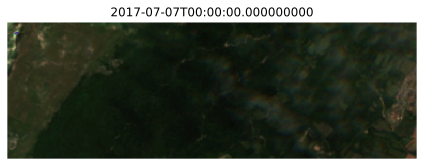

In [108]:
# Plot the first date

rgb_plots = mc[["s2_B04", "s2_B03", "s2_B02"]].to_array("band")
rgb_plots = rgb_plots.where(rgb_plots != 65535, np.nan)
#rgb_plots = rgb_plots.where(~rgb_plots.isnull().any(dim='band')) # if any of the bands is missing, mask out pixel
rgb_plots = rgb_plots/10000

# Calculate global min and max for each band
global_min = rgb_plots.min(dim=['time', 'lat', 'lon'])
global_max = rgb_plots.max(dim=['time', 'lat', 'lon'])

# Set up the figure and axes
num_im = len(mc.time)
fig, ax = plt.subplots(1, 1, figsize=(6,6))

i = 30
rgb_time = rgb_plots.isel(time=i)

# Rescale to 0-255
rescaled_arr = np.empty_like(rgb_time, dtype=np.uint8)

for b in range(rgb_time.shape[0]):
      band_data = rgb_time[b]  # Select data for the current band
      # Calculate the min and max values for the current band
      band_min = global_min[b]
      band_max = global_max[b]
      # Rescale the data for the current band to 0-255 range
      rescaled_band = ((band_data - band_min) * (1 / (band_max - band_min) * 255)).astype(np.uint8)
      # Assign the rescaled data to the corresponding band in the new array
      rescaled_arr[b] = rescaled_band*5 #x 5 to brighten the image
      

# Plot the RGB image for the current time step and image
ax.imshow(rescaled_arr.transpose(1,2,0), vmin=0, vmax=1) #transpose('lat', 'lon', 'band')
ax.set_title(f"{str(mc.time.values[i])}")  
ax.axis('off')  # Turn off axis  
      
plt.tight_layout()
plt.show()